In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-twitter-27b-200d-txt/glove.twitter.27B.200d.txt


In [2]:
# install packages
!pip install seaborn=="v0.13.2" # supress "Futurewarning for deprecated pandas is_categorical_dtype and use_inf_as_na usage"
!pip install emoji
!pip install autocorrect
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=5b8b2ab17946cbf7ecb44cf5bb36d0c346d19552d6b5189d8e92556867f151ae
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.7 MB/s eta 0:00:00


In [3]:
# import necessary packages
# import necessary library
import contractions
import emoji
import os
import re
import string
import urllib.parse

from autocorrect import Speller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU, SimpleRNN
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from numpy.random import seed
seed(1000)
from tensorflow.random import set_seed
set_seed(1000)
print(f'TensorFlow version: {tf.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'NLTK version: {nltk.__version__}')

TensorFlow version: 2.17.1
Seaborn version: 0.13.2
NLTK version: 3.2.4


In [4]:
# setup environment
BASE_DIR = '/kaggle/input/nlp-getting-started'

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [5]:
# load train, test, sample_submission.csv
df_train = pd.read_csv(f'{BASE_DIR}/train.csv')
df_test = pd.read_csv(f'{BASE_DIR}/test.csv')
sample_submission_data = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

## Description of the problem/data

In this problem, the task is to determine whether a human is tweeting about a disaster or not.

Upon reviewing the given data structure, we can see that the training data contains the fields: id, keyword, location, text, and target. The value of the target (either 0 or 1) indicates whether the tweet is related to a disaster or not. The test data, of course, does not include the target field but contains id, keyword, location, and text.

The output CSV file should contain the id and a classification (0 or 1) indicating whether the tweet is related to a disaster or not.

In this case, the evaluation is based on the F1 score, not accuracy. The formula for calculating the F1 score is given below:
> $$
F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$
where:
$$
\text{precision} = \frac{TP}{TP + FP}
$$
$$
\text{recall} = \frac{TP}{TP + FN}
$$
> - True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
> - False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
> - False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

This is clearly an NLP-related problem, where the task is to build a model that predicts whether a disaster is occurring based on the content of a tweet.

In [6]:
# check the contents of train, test csv
def show_data_structure(dataframe, label):
    print(f'{label} set shape: {dataframe.shape}')
    print(f'{label} set memory usage: {dataframe.memory_usage().sum() / 1024**2} MB')

show_data_structure(df_train, label='train')
show_data_structure(df_test, label='test')

train set shape: (7613, 5)
train set memory usage: 0.29053497314453125 MB
test set shape: (3263, 4)
test set memory usage: 0.099700927734375 MB


In [7]:
# check the submission format
sample_submission_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [8]:
# peek the train data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# peek the test data
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis (EDA)

Upon reviewing the train and test CSV data, the following fields are included:
- id
- keyword: The keyword of the tweet (nullable)
- location: The location from which the tweet was sent (nullable)
- text: The text of the tweet
- target: 1 if the tweet indicates an actual disaster, 0 otherwise. This field is not present in the test.csv.

In [10]:
# count the text length and add the length feature and then show the statistics
def add_text_length_and_show_statistics(dataframe, label):
    dataframe['length'] = dataframe.text.apply(lambda x: len(x))
    print(f'{label} length stats')
    print(dataframe.length.describe())
    print('========================')


add_text_length_and_show_statistics(df_train, label='train')
add_text_length_and_show_statistics(df_test, label='test')

train length stats
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
test length stats
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


Check the cardinality of the keyword and location.

Cardinality refers to the number of distinct unique values in the data.

Low cardinality refers to cases where there are few unique values.
High cardinality refers to cases where there are many unique values.
The issues with high cardinality are:

The model may become over-optimized for the training data.
Using One-Hot Encoding can increase memory usage and computation.
Data cleaning becomes challenging. If input is left to the user, the same location might be represented differently due to inconsistencies in notation.

Looking at the following graph, it seems that location has high cardinality, and it may be better not to use it.

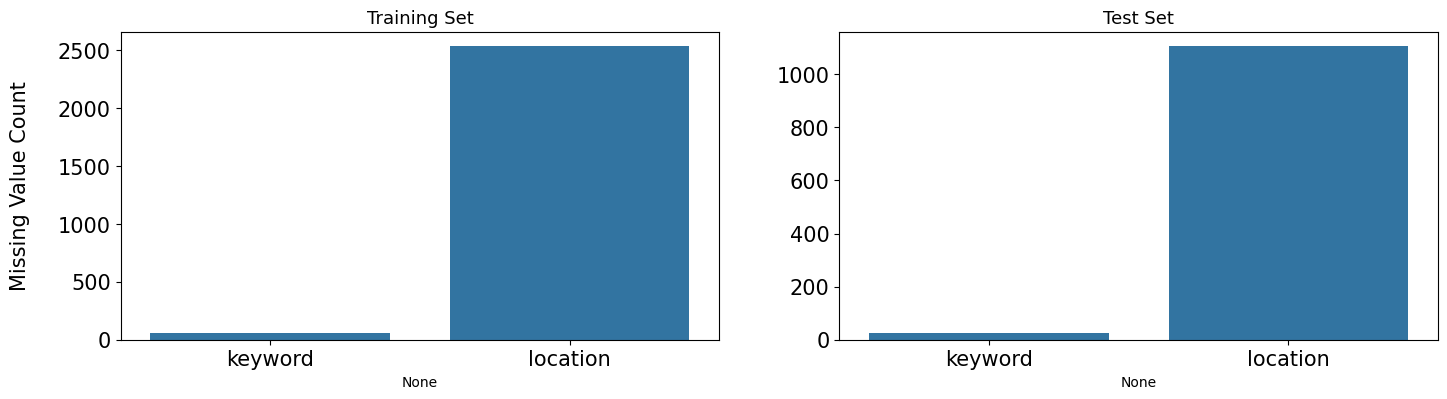

In [11]:
# missing values of keyword and location
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [12]:
# unique values of keyword and location
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


Examine the distribution of keywords for both the train and test datasets. Display the number of 0s and 1s corresponding to each keyword in a graph.

Given the presence of keywords such as "derailment" and "debris," which are associated with disasters, the keyword may be an important feature for predicting disasters. Additionally, since there are spaces like "%20" or similar words mixed in, if we can group these keywords more effectively, they might become a better indicator.

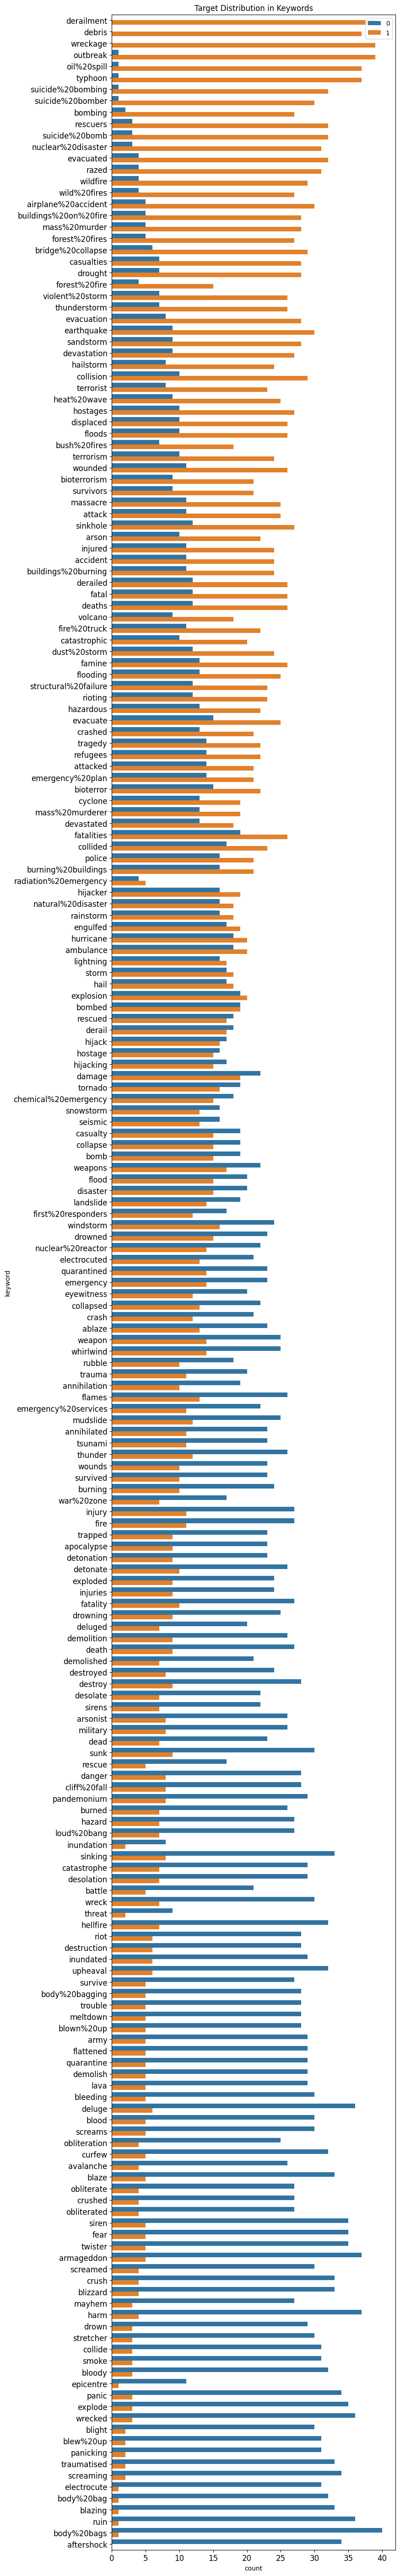

In [13]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target']
              )
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

df_train.drop(columns=['target_mean'], inplace=True)

Upon checking the distribution of the target values in the train data, it is observed that there are slightly more 0s than 1s, indicating that there is no significant imbalance in the data.

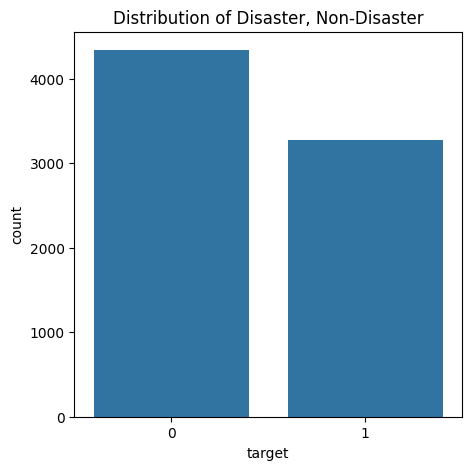

In [14]:
def plot_distribution_target():
    fig, ax = plt.subplots(figsize = (5, 5))
    graph = sns.countplot(x = 'target', data = df_train)
    plt.title('Distribution of Disaster, Non-Disaster')
    plt.show(graph)
plot_distribution_target()

Plot the distribution of metadata for non-disaster and disaster data, as well as the metadata for training data vs test data. It is observed that there are no significant differences between the training and test data in terms of their distribution.

The metadata includes:
- word_count: number of words in text
- unique_word_count: number of unique words in text
- stop_word_count: number of stop words in text
- url_count: number of urls in text
- mean_word_length: average character count in words
- char_count number: of characters in text
- punctuation_count: number of punctuations in text
- hashtag_count: number of hashtags (#) in text
- mention_count: number of mentions (@) in text

In [15]:
# add the meta feature 
## word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

## unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

## stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

## mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

## punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

## hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

## mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

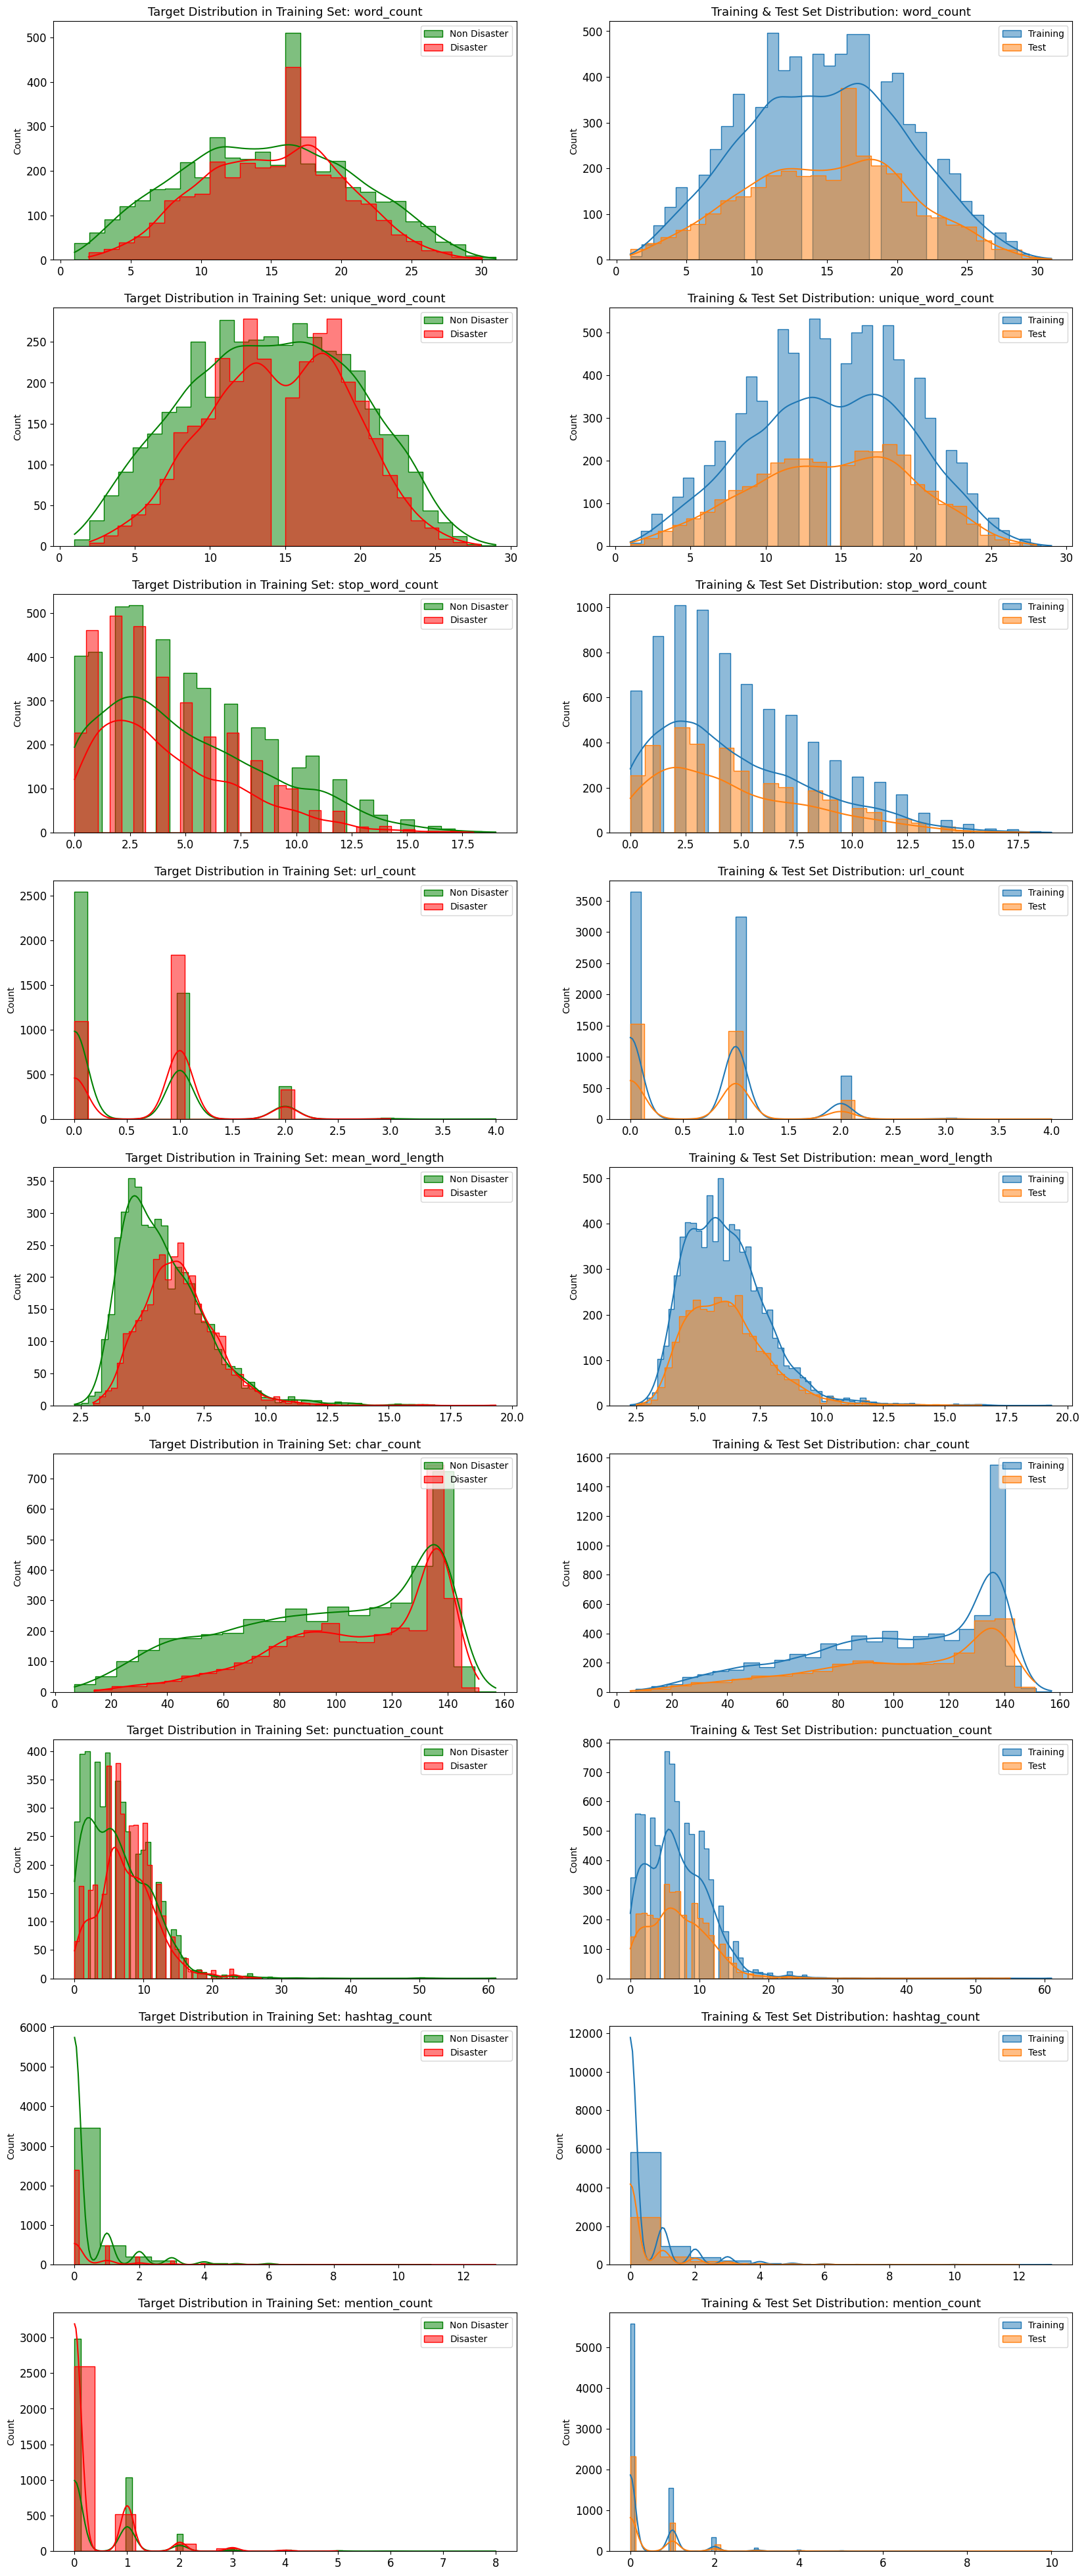

In [16]:
# plot the data
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1
fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    # plot disaster vs non-disaster distribution
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], 
                 label='Non Disaster', 
                 ax=axes[i][0], 
                 color='green',
                 element='step',
                 kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], 
                 label='Disaster', 
                 ax=axes[i][0], 
                 color='red',
                 element='step',
                 kde=True)
    # plot training vs test data distribution
    sns.histplot(df_train[feature], 
                 label='Training', 
                 ax=axes[i][1],
                 element='step',
                 kde=True)
    sns.histplot(df_test[feature], 
                 label='Test', 
                 ax=axes[i][1],
                 element='step',
                 kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'Target Distribution in Training Set: {feature}', fontsize=13)
    axes[i][1].set_title(f'Training & Test Set Distribution: {feature}', fontsize=13)

plt.show()

### Cleaning
Next, we will cleanse the data for use in our NLP model. The cleansing will focus on the keyword and text fields. The location field has high cardinality, and there are likely discrepancies due to user input variations. Although it is a potentially useful feature, we have decided not to use it in this study.

In [17]:
# define cleaning function
#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in STOPWORDS])
## remove url
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
## remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
## remove emojis
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')
## Remove punctuations
def remove_punctuations(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
## Decode URL Encode
def decode_url_encoding(x):
    if type(x) is not str:
        return x
    return " ".join([urllib.parse.unquote(i) for i in x.split()])
## Expand words
def expand_words(x):
    return " ".join([contractions.fix(i) for i in x.split()])
## Lemmatize words
WNL = WordNetLemmatizer()
def lemmatize_words(x):
    if type(x) is not str:
        return x
    return " ".join([WNL.lemmatize(i, pos='v') for i in x.split()])

## Spellcheck and auto-correct
def spell_check(x):
    if type(x) is not str:
        return x

    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

In [18]:
# clean the text
#remove stopwords
df_train['text']=df_train['text'].apply(lambda x : remove_stopwords(x))
df_test['text']=df_test['text'].apply(lambda x : remove_stopwords(x))

## Remove url
df_train['text']=df_train['text'].apply(lambda x : remove_url(x))
df_test['text']=df_test['text'].apply(lambda x : remove_url(x))

## Remove HTML tags
df_train['text']=df_train['text'].apply(lambda x : remove_html(x))
df_test['text']=df_test['text'].apply(lambda x : remove_html(x))

## Remove Emojis
df_train['text']=df_train['text'].apply(lambda x : remove_emoji(x))
df_test['text']=df_test['text'].apply(lambda x : remove_emoji(x))

## Remove punctuations
df_train['text']=df_train['text'].apply(lambda x : remove_punctuations(x))
df_test['text']=df_test['text'].apply(lambda x : remove_punctuations(x))

## Decode URL Encode
df_train['keyword']=df_train['keyword'].apply(lambda x : decode_url_encoding(x))
df_test['keyword']=df_test['keyword'].apply(lambda x : decode_url_encoding(x))

## Expand words
df_train['text']=df_train['text'].apply(lambda x : expand_words(x))
df_test['text']=df_test['text'].apply(lambda x : expand_words(x))

## Lemmatize words
df_train['text']=df_train['text'].apply(lambda x : lemmatize_words(x))
df_test['text']=df_test['text'].apply(lambda x : lemmatize_words(x))
df_train['keyword']=df_train['keyword'].apply(lambda x : lemmatize_words(x))
df_test['keyword']=df_test['keyword'].apply(lambda x : lemmatize_words(x))

In [19]:
# Spell check and auto-correct
## it takes long so this time it is not used in this study.
# df_train['text']=df_train['text'].apply(lambda x : spell_check(x))
# df_test['text']=df_test['text'].apply(lambda x : spell_check(x))
# df_train['keyword']=df_train['keyword'].apply(lambda x : spell_check(x))
# df_test['keyword']=df_test['keyword'].apply(lambda x : spell_check(x))

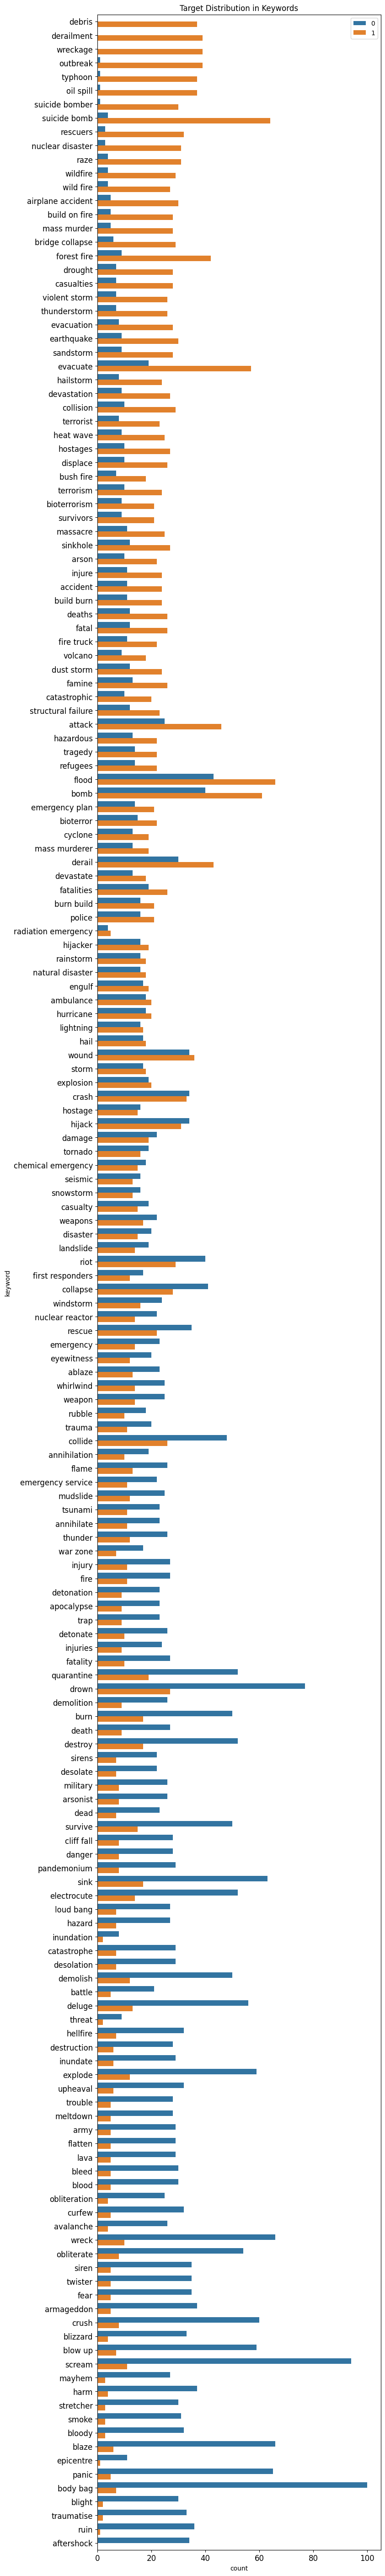

In [20]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target']
              )
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

df_train.drop(columns=['target_mean'], inplace=True)

By generating a Word Cloud, we can observe the differences in the words used in disaster and non-disaster tweets. In the case of real disaster tweets, it becomes clear that words more closely related to disasters are more prominently displayed.

In [21]:
def create_corpus(dataframe, target):
    corpus=[]
    for x in dataframe[dataframe['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

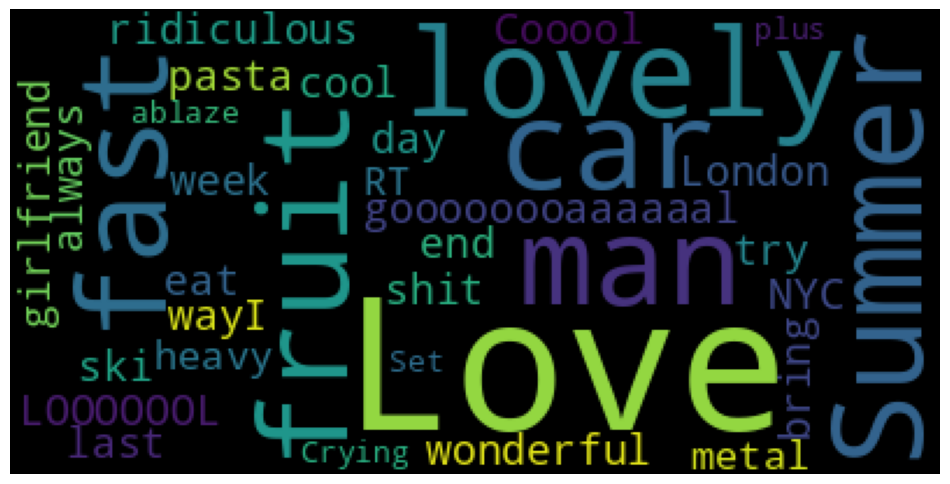

In [22]:
# Generating the wordcloud with the values under the non disaster
corpus_new0=create_corpus(df_train,0)
len(corpus_new0)
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

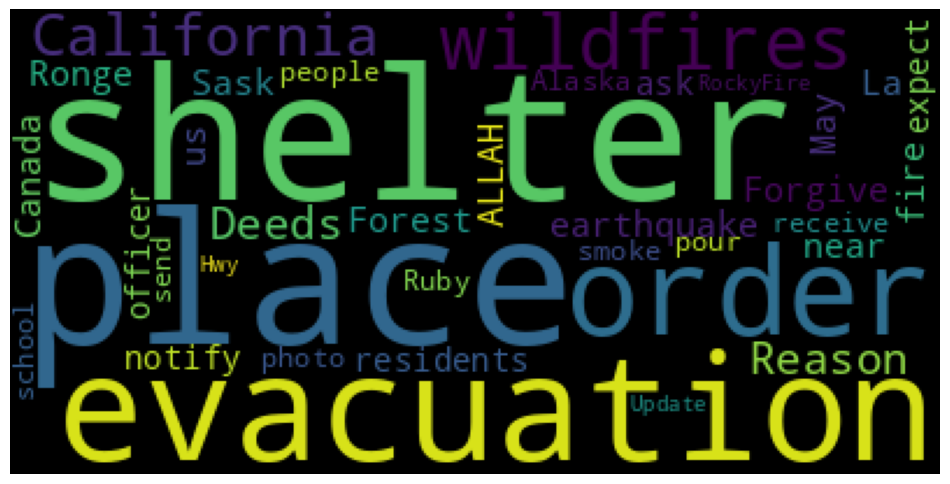

In [23]:
# Generating the wordcloud with the values under the real disaster
corpus_new1=create_corpus(df_train,1)
len(corpus_new1)
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                       max_font_size = 80
                       ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In this case, we will check with 2-word and 3-word combinations. When using 3 words, it seems that there are more tweets that are specifically related to disasters.

In [24]:
def get_top_tweet_ngrams(corpus, ngram=2,  n=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


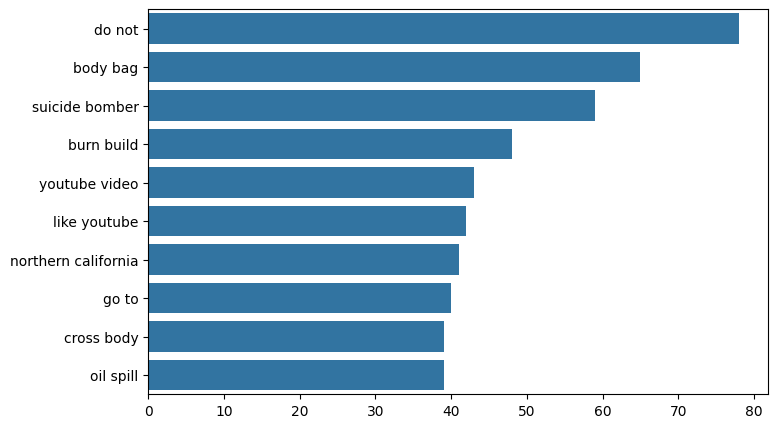

In [25]:
# plot 2-gram
plt.figure(figsize=(8,5))
top_tweet_bigrams=get_top_tweet_ngrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.show()

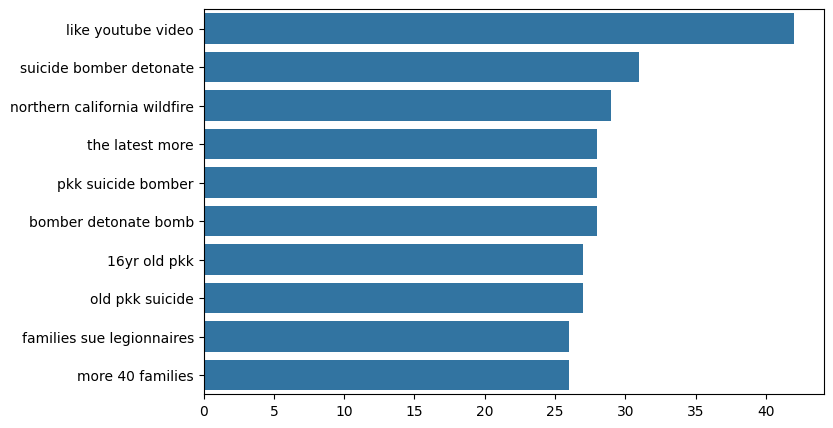

In [26]:
# plot 3-gram
plt.figure(figsize=(8,5))
top_tweet_bigrams=get_top_tweet_ngrams(df_train['text'], ngram=3)[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.show()

## Model Architecture

Word Embeddings is a technique that converts words into numerical vector representations. This technique ensures that similar words are represented by similar vectors. As a result, machine learning models can more easily learn the semantic relationships between words. There are various techniques to vectorize words.

Bag of Words (BoW) is a method that vectorizes the frequency of word occurrences in a sentence, while TF-IDF (Term Frequency - Inverse Document Frequency) evaluates the importance of words within a document and vectorizes them accordingly. These vectorization methods, however, ignore context and word order, which could potentially lead to misclassification if only the word itself is used.

On the other hand, GloVe (Global Vectors for Word Representation) is based on a co-occurrence matrix and can statistically capture the semantic relationships between words. Since GloVe takes into account the overall context of words, it seems more suitable for this task. Therefore, GloVe has been chosen for its ability to capture semantic relationships between words in word embedding models.

The model will be evaluated using the following four approaches:

1. Simple RNN: (embedding -> SpatialDropout1D(0.2) -> SimpleRNN) + meta_info -> Dense(128) -> Dropout(0.2) -> Dense(1)
2. LSTM: (embedding -> SpatialDropout1D(0.2) -> LSTM) + meta_info -> Dense(128) -> Dropout(0.2) -> Dense(1)
3. Bidirectional LSTM: (embedding -> SpatialDropout1D(0.2) -> Bidirectional LSTM) + meta_info -> Dense(128) -> Dropout(0.2) -> Dense(1)
4. GRU: (embedding -> SpatialDropout1D(0.2) -> GRU) + meta_info -> Dense(128) -> Dropout(0.2) -> Dense(1)

Perform preprocessing to handle both text data and keywords together and apply them as embedded data for GloVe.

In [27]:
# preprocessing
## store the test ids
test_ids = df_test['id']
## store the train labels
labels = df_train['target']

## drop id location column
columns = {'id', 'location'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

## concatenate text and keyword
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')
df_train['text'] = df_train['text'] + ' ' + df_train['keyword']
df_test['text'] = df_test['text'] + ' ' + df_test['keyword']

## drop keyword
columns = {'keyword'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

## drop target in train data
df_train = df_train.drop(columns = 'target')

In [28]:
all_text = pd.concat([df_train['text'], df_test['text']], axis=0)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
sequences = tokenizer.texts_to_sequences(all_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
train_data = data[:len(df_train)]
test_data = data[len(df_train):]
print('Shape of train data tensor:', train_data.shape)
print('Shape of test data tensor:', test_data.shape)
print('Shape of label tensor:', labels.shape)
MAX_SEQUENCE_LENGTH = train_data.shape[1]

Found 21436 unique tokens.
Shape of train data tensor: (7613, 29)
Shape of test data tensor: (3263, 29)
Shape of label tensor: (7613,)


We will use the 200d version of GloVe trained on Twitter data. There are versions trained on Wikipedia and Twitter, and the Twitter version is said to be more suitable for social media-like data.

Since we are using Twitter data, we will use this version, so the embedding dimension will be 200.

> https://nlp.stanford.edu/projects/glove/

In [29]:
EMBEDDING_DIM = 200

In [30]:
# load GloVe vector embeddings
glove_dictionary = {}
with open('../input/glove-twitter-27b-200d-txt/glove.twitter.27B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dictionary[word] = coefs

print('Found %s word vectors in the GloVe library' % len(glove_dictionary))

1193514it [01:13, 16197.30it/s]

Found 1193514 word vectors in the GloVe library


In [31]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, index in tqdm(word_index.items()):
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 21436/21436 [00:00<00:00, 282929.65it/s]

Our embedded matrix is of dimension (21437, 200)


Since GloVe is already pre-trained, there will be no further training.

In [32]:
# build Embedding layer
embedding = Embedding(input_dim = len(word_index) + 1,
                      output_dim = EMBEDDING_DIM, 
                      weights = [embedding_matrix],
                      trainable = False
                     )

Standardize all metadata other than text data so that the mean is 0 and the variance is 1.

In [33]:
def standardize(df, scaler):
    return scaler.fit_transform(df)
meta_train = standardize(df_train.drop(columns={'text'}), StandardScaler())
meta_test = standardize(df_test.drop(columns={'text'}), StandardScaler())
META_LENGTH = meta_train.shape[1]

In [34]:
# simple rnn
def create_rnn(embedding, spatial_dropout, dropout, recurrent_dropout, learning_rate):
    # input layers
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (META_LENGTH, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)
    
    # add SimpleRNN layer
    nlp_out = SimpleRNN(units = 128,
                        activation = 'tanh',
                        dropout = dropout, 
                        recurrent_dropout = recurrent_dropout,
                        kernel_initializer = 'orthogonal')(emb)
    # add meta data
    x = Concatenate()([nlp_out, meta_input_train])

    # hidden layer
    x = Dense(128, activation = LeakyReLU(negative_slope = 0.01), kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal')(x)
    x = Dropout(dropout)(x)
    
    # add output layer
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

In [35]:
# lstm
def create_lstm(embedding, spatial_dropout, dropout, recurrent_dropout, learning_rate):
    # input layers
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (META_LENGTH, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    # add LSTM layer
    nlp_out = LSTM(128, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')(emb)
    # add meta data
    x = Concatenate()([nlp_out, meta_input_train])

    # hidden layer
    x = Dense(128, activation = LeakyReLU(negative_slope = 0.01), kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal')(x)
    x = Dropout(dropout)(x)
    
    # add output layer
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

In [36]:
# bidirectional lstm
def create_bidirectional_lstm(embedding, spatial_dropout, dropout, recurrent_dropout, learning_rate):
    # input layers
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (META_LENGTH, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    # add bidirectional LSTM layer
    nlp_out = Bidirectional(LSTM(128, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
  
    # add meta data
    x = Concatenate()([nlp_out, meta_input_train])

    # hidden layer
    x = Dense(128, activation = LeakyReLU(negative_slope = 0.01), kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal')(x)
    x = Dropout(dropout)(x)
    
    # add output layer
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

In [37]:
# GRU
def create_gru(embedding, spatial_dropout, dropout, recurrent_dropout, learning_rate):
    # input layers
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (META_LENGTH, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    # add GRU layer
    nlp_out = GRU(128, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')(emb)
  
    # add meta data
    x = Concatenate()([nlp_out, meta_input_train])

    # hidden layer
    x = Dense(128, activation = LeakyReLU(negative_slope = 0.01), kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal')(x)
    x = Dropout(dropout)(x)
    
    # add output layer
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

In [38]:
simple_rnn = create_rnn(embedding = embedding, 
                   spatial_dropout = .2, 
                   dropout = .2, 
                   recurrent_dropout = .2,
                   learning_rate = 3e-4)
simple_rnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 29, 200)        │      4,287,400 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d         │ (None, 29, 200)        │              0 │ embedding[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 128)            │         42,112 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_train (InputLayer)   │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 138)            │              0 │ simple_rnn[0][0],      │
│                           │                        │                │ meta_train[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         17,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,347,433 (16.58 MB)

 Trainable params: 60,033 (234.50 KB)

 Non-trainable params: 4,287,400 (16.36 MB)

In [39]:
# create lstm
lstm = create_lstm(embedding = embedding, 
                   spatial_dropout = .2, 
                   dropout = .2, 
                   recurrent_dropout = .2,
                   learning_rate = 3e-4)
lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 29, 200)        │      4,287,400 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_1       │ (None, 29, 200)        │              0 │ embedding[1][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        168,448 │ spatial_dropout1d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_train (InputLayer)   │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 138)            │              0 │ lstm[0][0],            │
│ (Concatenate)             │                        │                │ meta_train[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         17,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,473,769 (17.07 MB)

 Trainable params: 186,369 (728.00 KB)

 Non-trainable params: 4,287,400 (16.36 MB)

In [40]:
# create create_bidirectional_lstm
bidirectional_lstm = create_bidirectional_lstm(embedding = embedding, 
                                               spatial_dropout = .2, 
                                               dropout = .2, 
                                               recurrent_dropout = .2,
                     learning_rate = 3e-4)
bidirectional_lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 29, 200)        │      4,287,400 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_2       │ (None, 29, 200)        │              0 │ embedding[2][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        336,896 │ spatial_dropout1d_2[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_train (InputLayer)   │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 266)            │              0 │ bidirectional[0][0],   │
│ (Concatenate)             │                        │                │ meta_train[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         34,176 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,658,601 (17.77 MB)

 Trainable params: 371,201 (1.42 MB)

 Non-trainable params: 4,287,400 (16.36 MB)

In [41]:
# create gru
gru = create_gru(embedding = embedding,
                 spatial_dropout = .2,
                 dropout = .2,
                 recurrent_dropout = .2,
                 learning_rate = 3e-4)
gru.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 29, 200)        │      4,287,400 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_3       │ (None, 29, 200)        │              0 │ embedding[3][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 128)            │        126,720 │ spatial_dropout1d_3[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_train (InputLayer)   │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 138)            │              0 │ gru[0][0],             │
│ (Concatenate)             │                        │                │ meta_train[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         17,792 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,432,041 (16.91 MB)

 Trainable params: 144,641 (565.00 KB)

 Non-trainable params: 4,287,400 (16.36 MB)

In [42]:
# simple rnn
history1 = simple_rnn.fit([train_data, meta_train], 
                    labels,
                    validation_split = .2,
                    epochs = 10, 
                    batch_size = 32,
                    verbose = True)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5741 - loss: 0.7390 - precision: 0.4994 - recall: 0.5545 - val_accuracy: 0.7603 - val_loss: 0.5340 - val_precision: 0.8539 - val_recall: 0.5853
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7167 - loss: 0.5854 - precision: 0.6789 - recall: 0.6163 - val_accuracy: 0.7577 - val_loss: 0.5342 - val_precision: 0.8935 - val_recall: 0.5444
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7476 - loss: 0.5519 - precision: 0.7289 - recall: 0.6355 - val_accuracy: 0.7695 - val_loss: 0.5250 - val_precision: 0.8943 - val_recall: 0.5726
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7656 - loss: 0.5233 - precision: 0.7552 - recall: 0.6563 - val_accuracy: 0.7794 - val_loss: 0.4921 - val_precision: 0.8607 - val_recall: 0.6276
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7766 - loss: 0.5144 - precision: 0.7811 - recall: 0.6523 - val_accuracy: 0.7827 - val_los

In [43]:
# lstm 
history2 = lstm.fit([train_data, meta_train], 
                    labels, 
                    validation_split = .2,
                    epochs = 10, 
                    batch_size = 32,
                    verbose = True)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6624 - loss: 0.6358 - precision: 0.6043 - recall: 0.5963 - val_accuracy: 0.7984 - val_loss: 0.4652 - val_precision: 0.8602 - val_recall: 0.6770
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7823 - loss: 0.5003 - precision: 0.7739 - recall: 0.6808 - val_accuracy: 0.8050 - val_loss: 0.4490 - val_precision: 0.8515 - val_recall: 0.7038
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7941 - loss: 0.4809 - precision: 0.8003 - recall: 0.6791 - val_accuracy: 0.8083 - val_loss: 0.4427 - val_precision: 0.8601 - val_recall: 0.7024
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8043 - loss: 0.4683 - precision: 0.8078 - recall: 0.7004 - val_accuracy: 0.8096 - val_loss: 0.4437 - val_precision: 0.8631 - val_recall: 0.7024
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8085 - loss: 0.4560 - precision: 0.8149 - recall: 0.7059 - val_accuracy: 0.8122 - val_lo

In [44]:
# bidirectional lstm
history3 = bidirectional_lstm.fit([train_data, meta_train], 
                    labels, 
                    validation_split = .2,
                    epochs = 10, 
                    batch_size = 32,
                    verbose = True)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6615 - loss: 0.6198 - precision: 0.6141 - recall: 0.4907 - val_accuracy: 0.8037 - val_loss: 0.4535 - val_precision: 0.8661 - val_recall: 0.6841
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7902 - loss: 0.4855 - precision: 0.7979 - recall: 0.6698 - val_accuracy: 0.8043 - val_loss: 0.4473 - val_precision: 0.8599 - val_recall: 0.6925
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8017 - loss: 0.4669 - precision: 0.8119 - recall: 0.6872 - val_accuracy: 0.8056 - val_loss: 0.4445 - val_precision: 0.8721 - val_recall: 0.6827
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8129 - loss: 0.4532 - precision: 0.8340 - recall: 0.6948 - val_accuracy: 0.8142 - val_loss: 0.4373 - val_precision: 0.8672 - val_recall: 0.7094
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8117 - loss: 0.4483 - precision: 0.8322 - recall: 0.6920 - val_accuracy: 0.8135 - va

In [45]:
# gru
history4 = gru.fit([train_data, meta_train], 
                    labels, 
                    validation_split = .2,
                    epochs = 10, 
                    batch_size = 32,
                    verbose = True)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6448 - loss: 0.6471 - precision: 0.5848 - recall: 0.5460 - val_accuracy: 0.7846 - val_loss: 0.5096 - val_precision: 0.7972 - val_recall: 0.7207
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7828 - loss: 0.5006 - precision: 0.7814 - recall: 0.6720 - val_accuracy: 0.7919 - val_loss: 0.4914 - val_precision: 0.8151 - val_recall: 0.7151
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7896 - loss: 0.4928 - precision: 0.7914 - recall: 0.6780 - val_accuracy: 0.7958 - val_loss: 0.4783 - val_precision: 0.8189 - val_recall: 0.7207
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8009 - loss: 0.4683 - precision: 0.8100 - recall: 0.6881 - val_accuracy: 0.8011 - val_loss: 0.4763 - val_precision: 0.8306 - val_recall: 0.7193
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8024 - loss: 0.4665 - precision: 0.8146 - recall: 0.6874 - val_accuracy: 0.8030 - val_lo

In [46]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].legend(['train', 'validation'], loc = 'upper left')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    fig.suptitle("Model Accuracy", fontsize=14)
    plt.show()


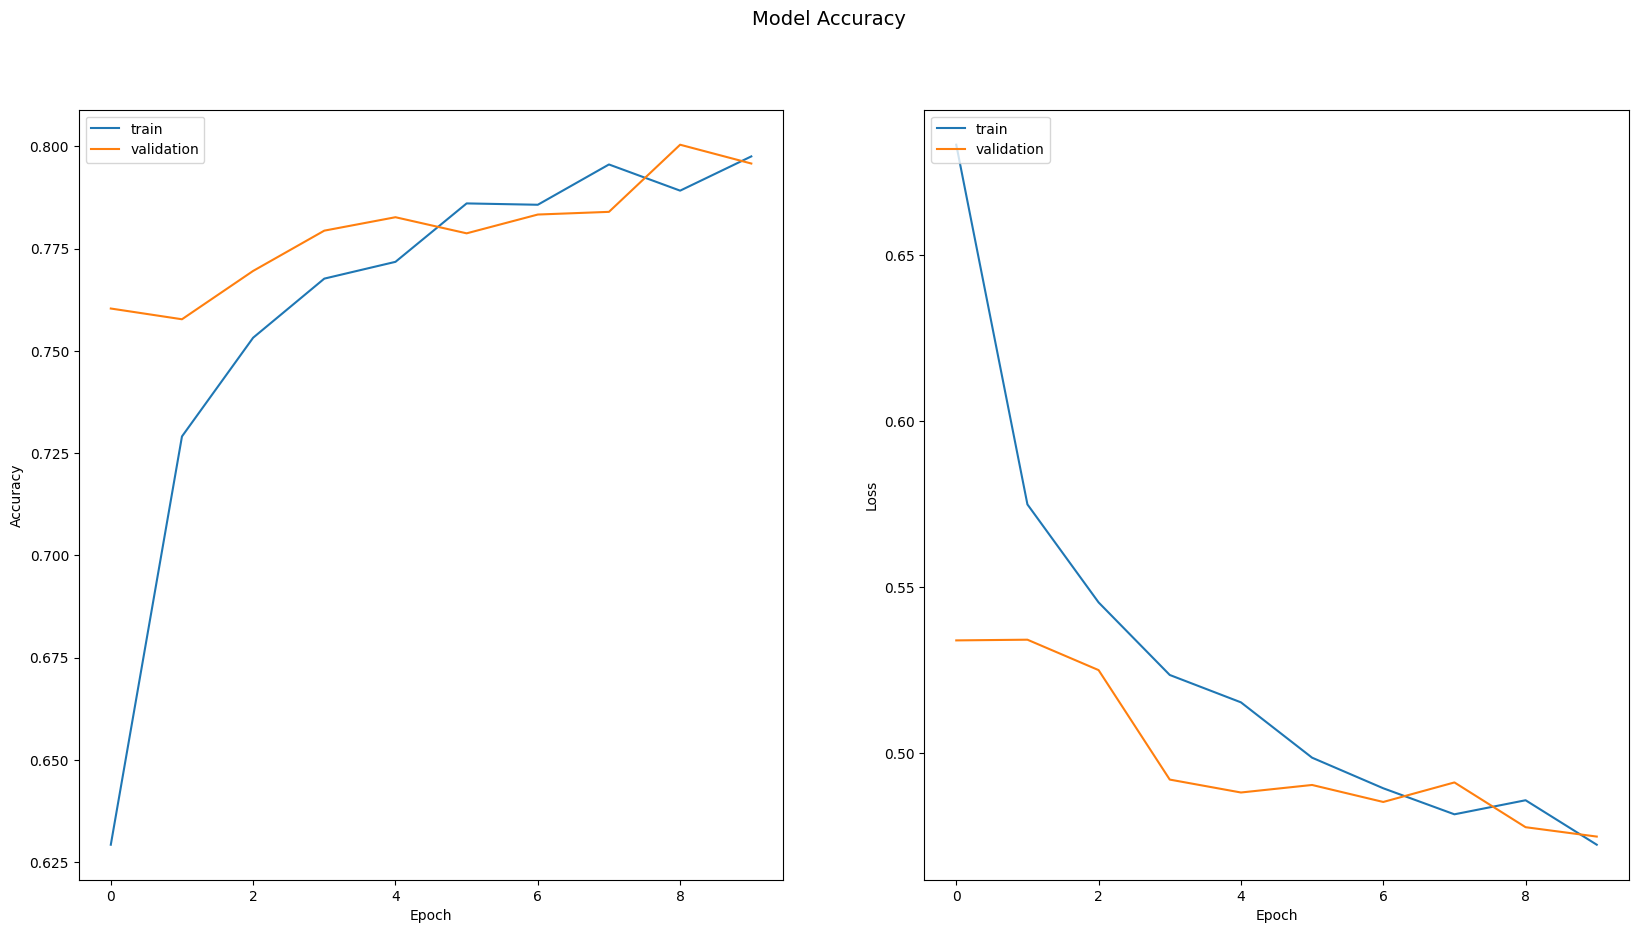

In [47]:
# learning curves of simple rnn
plot_learning_curves(history1)

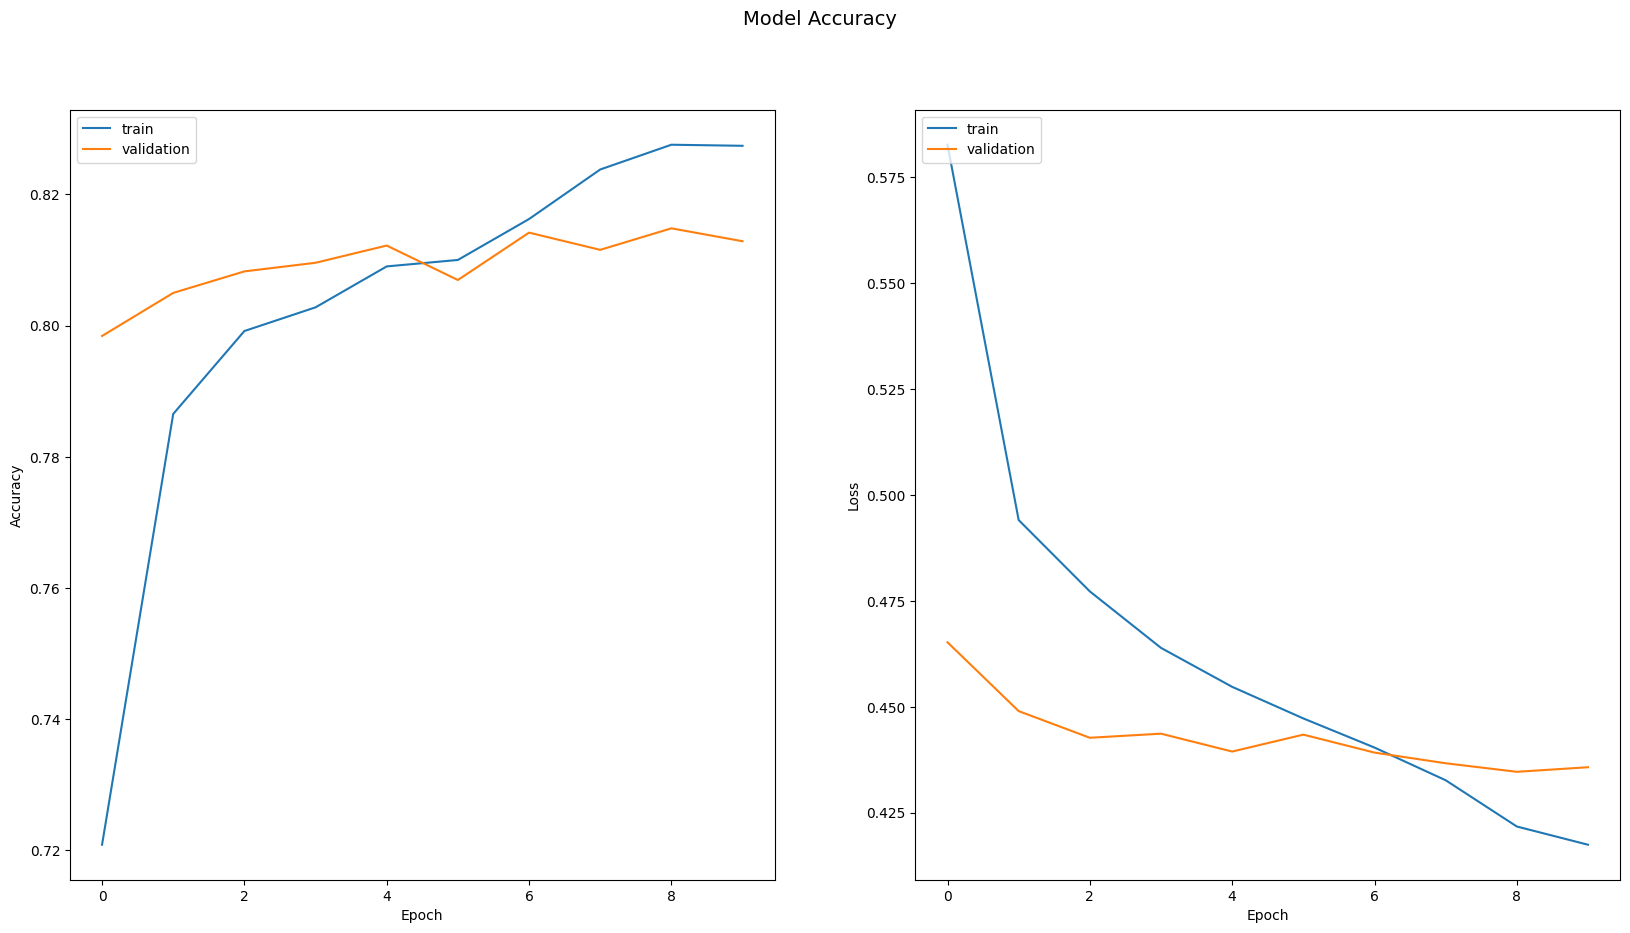

In [48]:
# learning curves of lstm
plot_learning_curves(history2)

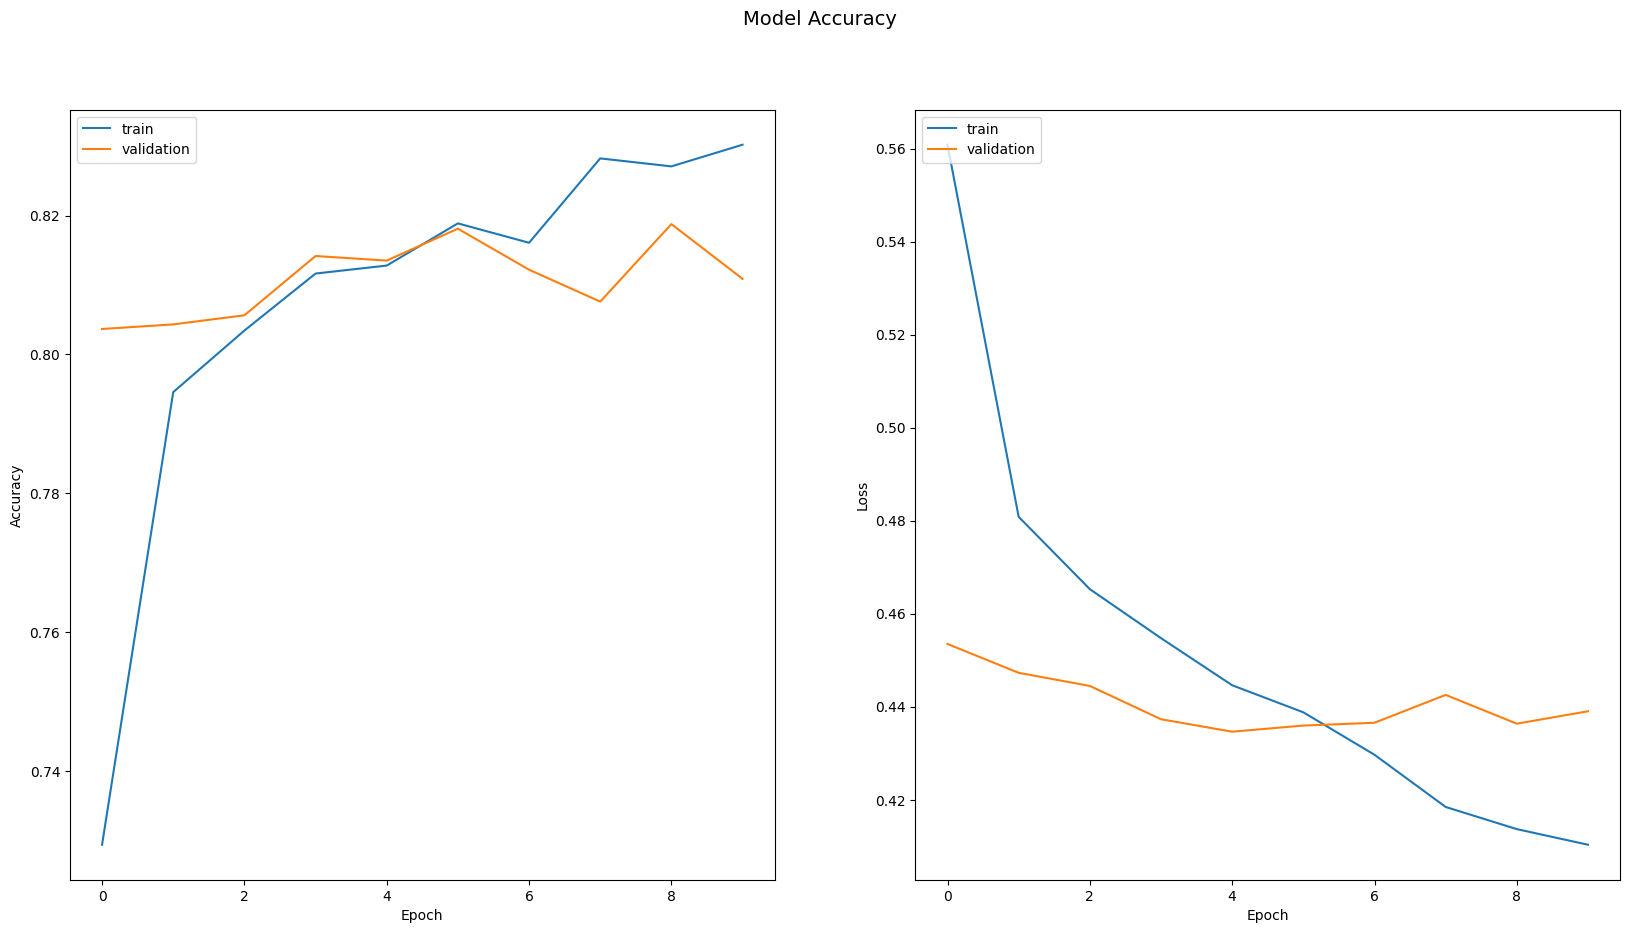

In [49]:
# learning curves of bi-directional lstm
plot_learning_curves(history3)

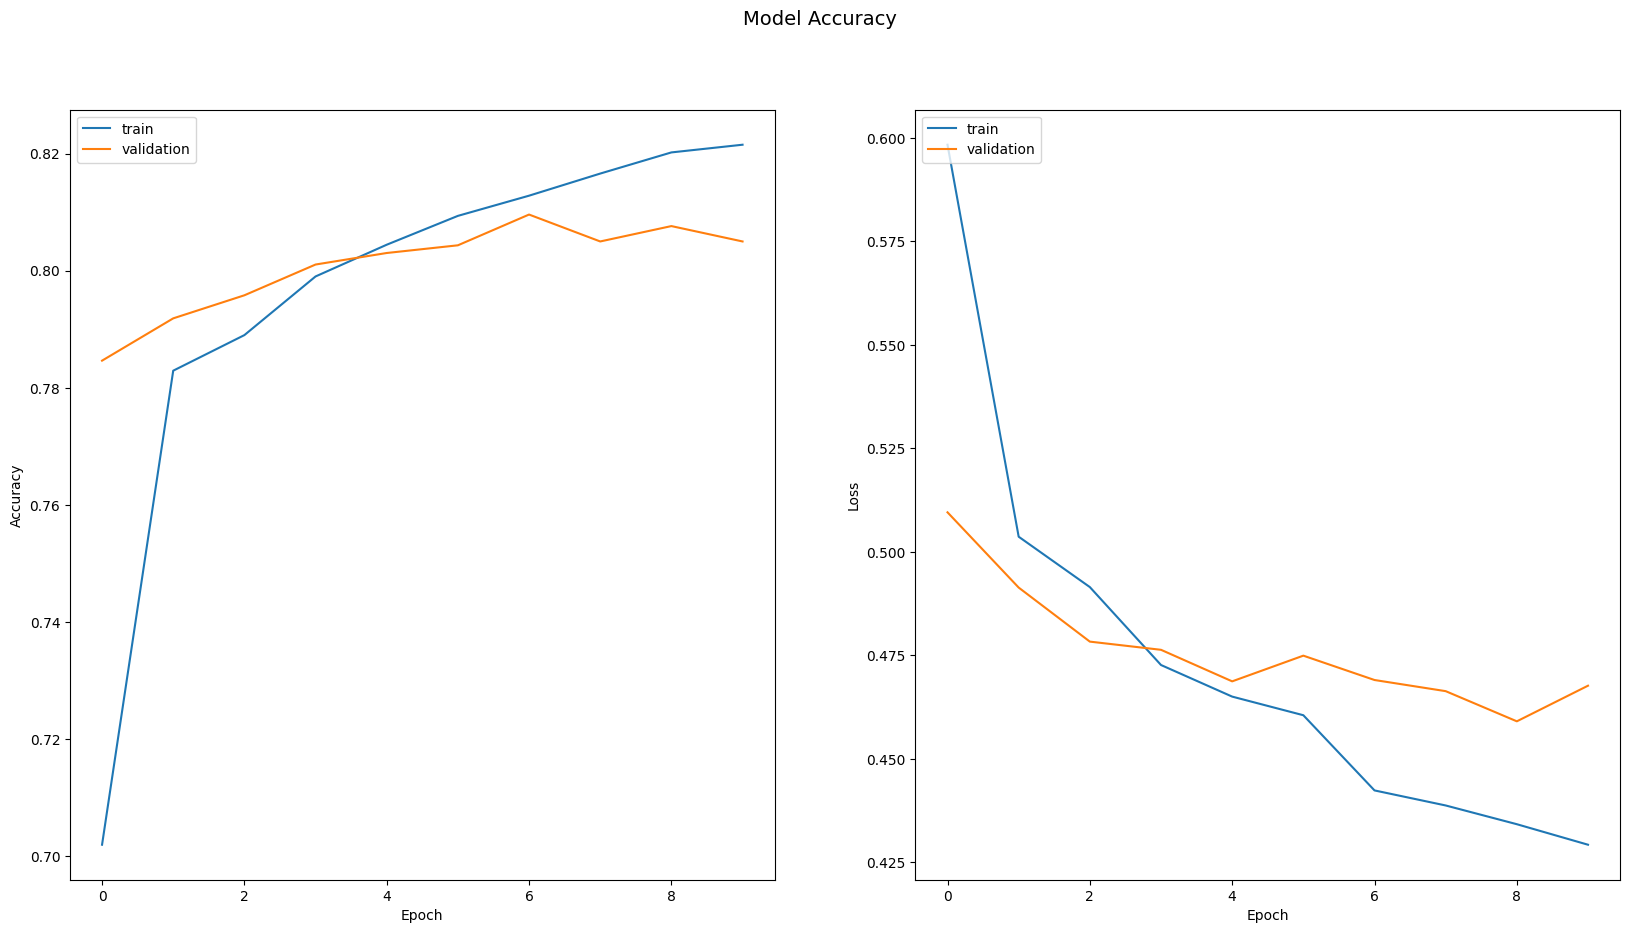

In [50]:
# learning curves of gru
plot_learning_curves(history4)

Plot the F1 score for model1, model2, and model3.

In [51]:
# plot F1 score each models
def calculate_f1_score(history):
    precision = np.array(history.history["precision"])
    recall = np.array(history.history["recall"])
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

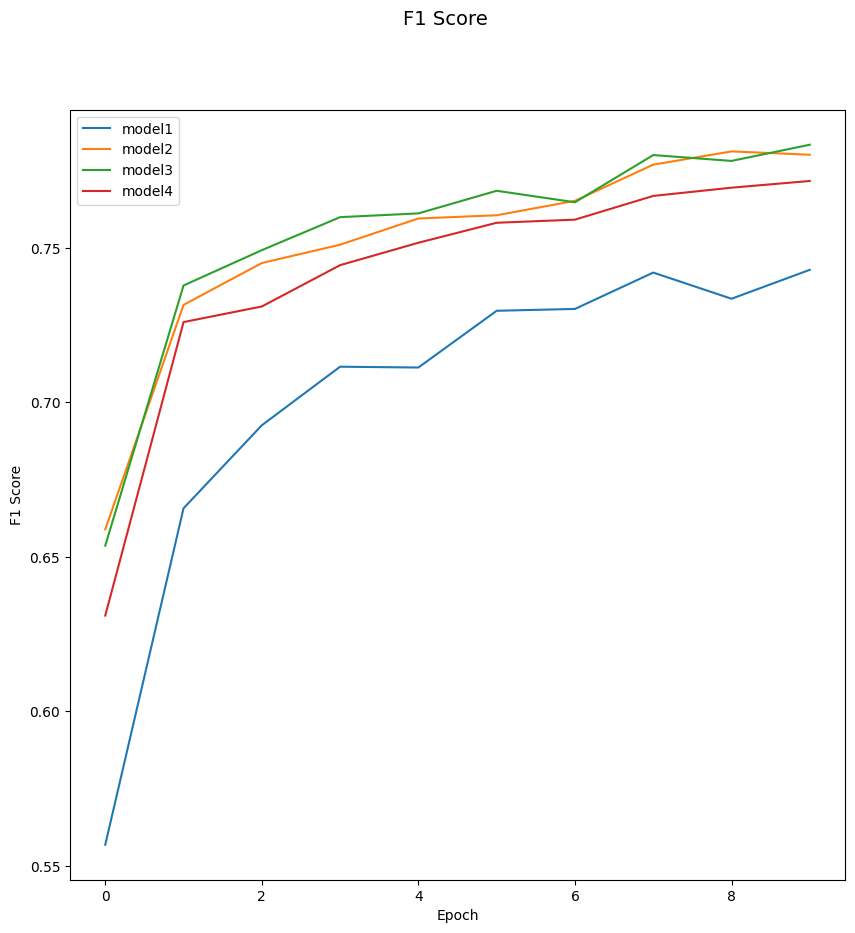

In [52]:
def plot_f1_score(histories):
    n = len(histories)
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    for i in range(n):
        history = histories[i]
        f1_score = calculate_f1_score(history)
        ax.plot(f1_score, label=f'model{i+1}')

    ax.legend(loc = 'upper left')
    fig.suptitle("F1 Score", fontsize=14)
    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Epoch')
    return plt.show()
plot_f1_score([history1, history2, history3, history4])

## Result & Analysis

Upon reviewing the results, it can be seen that both LSTM and bidirectional LSTM have better F1 scores than the Simple RNN. On the other hand, there doesn't seem to be a clear difference between LSTM, bidirectional LSTM, and GRU. Since RNN and LSTM involve sequential computations, it is expected that their training might be slow, so an epoch of 10 may not be sufficient. Therefore, I will increase the epoch to 30 and check again.

In [53]:
# compute each models in 30 epochs
lstm2 = create_lstm(embedding = embedding, 
                   spatial_dropout = .2, 
                   dropout = .2, 
                   recurrent_dropout = .2,
                   learning_rate = 3e-4)
history5 = lstm2.fit([train_data, meta_train], 
                    labels,
                    validation_split = .2,
                    epochs = 30, 
                    batch_size = 32,
                    verbose = True)

bidirectional_lstm2 = create_bidirectional_lstm(embedding = embedding, 
                                               spatial_dropout = .2, 
                                               dropout = .2, 
                                               recurrent_dropout = .2,
                                               learning_rate = 3e-4)
history6 = bidirectional_lstm2.fit([train_data, meta_train], 
                    labels,
                    validation_split = .2,
                    epochs = 30, 
                    batch_size = 32,
                    verbose = True)

gru2 = create_gru(embedding = embedding, 
                   spatial_dropout = .2, 
                   dropout = .2, 
                   recurrent_dropout = .2,
                   learning_rate = 3e-4)
history7 = gru2.fit([train_data, meta_train], 
                    labels,
                    validation_split = .2,
                    epochs = 30, 
                    batch_size = 32,
                    verbose = True)


Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6522 - loss: 0.6432 - precision: 0.5941 - recall: 0.5630 - val_accuracy: 0.7932 - val_loss: 0.4688 - val_precision: 0.8956 - val_recall: 0.6291
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7749 - loss: 0.4993 - precision: 0.7695 - recall: 0.6638 - val_accuracy: 0.8056 - val_loss: 0.4423 - val_precision: 0.8459 - val_recall: 0.7123
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7901 - loss: 0.4778 - precision: 0.7915 - recall: 0.6783 - val_accuracy: 0.8070 - val_loss: 0.4442 - val_precision: 0.8739 - val_recall: 0.6841
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7992 - loss: 0.4631 - precision: 0.8050 - recall: 0.6893 - val_accuracy: 0.8109 - val_loss: 0.4397 - val_precision: 0.8687 - val_recall: 0.6996
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8057 - loss: 0.4573 - precision: 0.8082 - recall: 0.7050 - val_accuracy: 0.8109 - val_lo

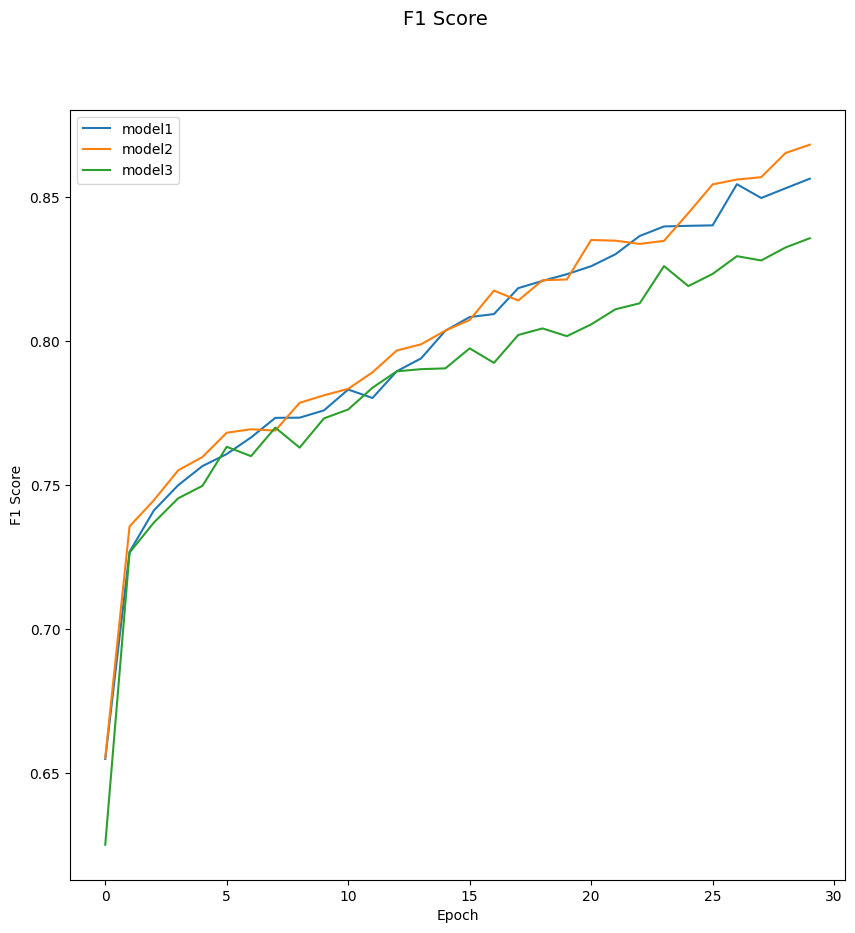

In [54]:
plot_f1_score([history5, history6, history7])

Upon reviewing the results, as expected, increasing the epochs seems to improve the F1 score. I will submit the results and check all the outcomes mentioned above.

In [55]:
def create_submission(models, test_data, meta_test):
    n = len(models)
    for i in range(n):
        model = models[i]
        submission = pd.DataFrame()
        submission['id'] = test_ids
        submission['predict'] = model.predict([test_data, meta_test])
        submission['target'] = submission['predict'].apply(lambda x: 0 if x < .5 else 1)
        submission = submission[['id', 'target']]
        submission.to_csv(f'submission_{i+1}.csv', index = False)

create_submission([simple_rnn, lstm, bidirectional_lstm, gru, lstm2, bidirectional_lstm2, gru2], test_data, meta_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


| Model               | epoch | public score |
|---------------------|-------|----------|
| RNN                 | 10    | 0.78792  |
| LSTM                | 10    | 0.81458  |
| Bi-directional LSTM | 10    | 0.81336  |
| GRU                 | 10    | 0.79313  |
| LSTM                | 30    | 0.81091  |
| Bi-directional LSTM | 30    | 0.80508  |
| GRU                 | 30    | 0.78547  |

It didn't go as expected and didn't work well. In fact, there is a possibility that the score isn't improving due to overfitting.

## Discussion/Conclusion

In this NLP task, we used RNN and LSTM to predict whether a tweet is related to a disaster or not. It was found that LSTM, bidirectional LSTM, and GRU perform better than the simple RNN.

To further improve the learning, the following points should be considered:

1. To prevent overfitting, use EarlyStopping.
2. In this case, we combined the keywords with the text as part of the input, but it might be better to analyze them separately.
3. In recent years, it has been shown that Transformer-based models using Attention Mechanism outperform RNN and LSTM. Unlike RNN and LSTM, Transformer does not perform sequential computations but is based on Self-Attention, which is known for its ability to parallelize and handle long-term memory effectively. We expect that using this model could dramatically improve performance.

## Reference
- https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert